In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [3]:
df.shape

(1361089, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1361089 entries, 0 to 1361088
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1361089 non-null  int64  
 1   type            1361089 non-null  object 
 2   amount          1361089 non-null  float64
 3   nameOrig        1361088 non-null  object 
 4   oldbalanceOrg   1361088 non-null  float64
 5   newbalanceOrig  1361088 non-null  float64
 6   nameDest        1361088 non-null  object 
 7   oldbalanceDest  1361088 non-null  float64
 8   newbalanceDest  1361088 non-null  float64
 9   isFraud         1361088 non-null  float64
 10  isFlaggedFraud  1361088 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 114.2+ MB


In [5]:
df.dtypes

,0
step,int64
type,object
amount,float64
nameOrig,object
oldbalanceOrg,float64
newbalanceOrig,float64
nameDest,object
oldbalanceDest,float64
newbalanceDest,float64
isFraud,float64


In [6]:
fraud_counts = df['isFraud'].value_counts()
fraud_percent = (fraud_counts / len(df)) * 100

print("Fraud vs Non-Fraud Counts:")
print(fraud_counts)
print("\nPercentage Distribution:")
print(fraud_percent)

Fraud vs Non-Fraud Counts:
isFraud
0.0    1359520
1.0       1568
Name: count, dtype: int64

Percentage Distribution:
isFraud
0.0    99.884725
1.0     0.115202
Name: count, dtype: float64


# Reducing the Dataset

In [7]:
fraud = df[df['isFraud'] == 1]
non_fraud = df[df['isFraud'] == 0].sample(n=30000, random_state=42)

df = pd.concat([fraud, non_fraud]).sample(frac=1, random_state=42).reset_index(drop=True)

print(df.shape)

(31568, 11)


In [8]:
fraud_counts = df['isFraud'].value_counts()
fraud_percent = (fraud_counts / len(df)) * 100

print("Fraud vs Non-Fraud Counts:")
print(fraud_counts)
print("\nPercentage Distribution:")
print(fraud_percent)

Fraud vs Non-Fraud Counts:
isFraud
0.0    30000
1.0     1568
Name: count, dtype: int64

Percentage Distribution:
isFraud
0.0    95.032945
1.0     4.967055
Name: count, dtype: float64


# Handling Missing Values

In [9]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


# Dropping unnecessary columns

In [10]:
df = df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

# Check and Remove duplicates

In [11]:
df.duplicated().sum()

np.int64(0)

In [12]:
df=df.drop_duplicates()
print(df.shape)
print(df.columns)

(31568, 8)
Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')


# Detecting Outliers

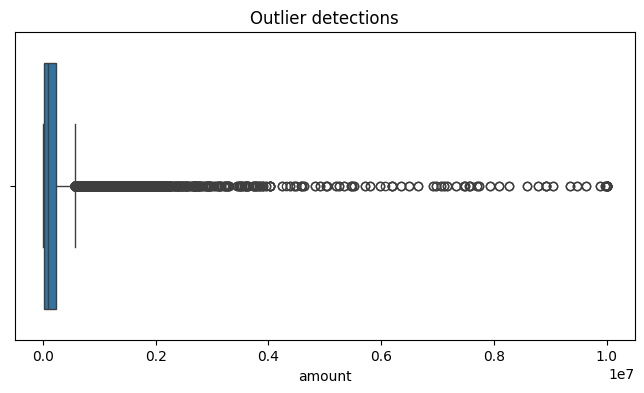

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.boxplot(x=df["amount"])
plt.title("Outlier detections")
plt.show()

# Datatype correction

In [14]:
df = pd.get_dummies(df, columns=["type"], drop_first=True)

In [15]:
df = df.rename(columns={"isFraud": "is_fraud"})

# Train Test split (80-20)

In [16]:
from sklearn.model_selection import train_test_split

X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((25254, 10), (6314, 10))

# Imbalence check in Class
Dataset is highly imbalenced and if we train directly then the accuracy will be 99% above even if everything is guessed as non fraud. The minority class patters cant be learnt
so we use SMOTE combining with classifiers for each model to handle the imbalence.

In [17]:
df["is_fraud"].value_counts()

,count
is_fraud,
0.0,30000
1.0,1568


What SMOTE (synthetic minority oversampling technique) does is it oversamples the minority class by creating syntietic samples by choosing the k nearest minority neighbours for each minority and create new points between then.

This is applied on the training set and it increases the number of fraud class samples.

In [18]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [19]:
y_train_smote.value_counts()

,count
is_fraud,
0.0,23982
1.0,23982


# Function to help evaluate models

In [23]:
def evaluate_model(name, model, X_test, y_test, pos_label=1):
  y_pred = model.predict(X_test)

  if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_test)[:,1]
  else:
    y_proba =model.decision_function(X_test)

  acc = accuracy_score(y_test, y_pred)
  proc = precision_score(y_test, y_pred, pos_label=pos_label)
  rec = recall_score(y_test, y_pred, pos_label=pos_label)
  f1 = f1_score(y_test, y_pred, pos_label=pos_label)
  auc = roc_auc_score(y_test, y_proba)

  print(f"Model: {name}")
  print(f"Accuracy: {acc:.2f}")
  print(f"Precision: {proc:.2f}")
  print(f"Recall: {rec:.2f}")
  print(f"F1 Score: {f1:.2f}")
  print(f"AUC: {auc:.2f}")
  print("\nConfucion matrix:")
  print(confusion_matrix(y_test, y_pred))
  print("\nClassification report:")
  print(classification_report(y_test, y_pred))

  return {
      "name": name,
      "model": model,
      "accuracy": acc,
      "precision": proc,
      "recall": rec,
      "f1_score": f1,
      "auc": auc
  }

In [24]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.model_selection import  GridSearchCV


from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# MODEL 1 - RANDOM FOREST

*Random forest* is an ensemble ML algo which builds multiple decision trees and combines their predictions to improve accuracy.

Each tree will be trained on random subset of data, rows and features, and then final prediction is made based on the majority outcome for this classification problem.

### Hyperparameters:
- n_estimators: (*number of trees*) More the number of trees the better is the performance but keeping training time in mind we used 100 adn 200
- max_depth: Tuning max depth with 10 and 20 which is a reasonable tree size cuz larger depth tend to overfitting
- min_sample_split and max_sample_split: restricting it to {2,5} and {1,2} respectively as the fraud cases are rare

### Metrics:
- scoring: Since fraud datasets are highly imbalanced and missing a fraud transaction is extremely costly, recall for the fraud class is the most suitable scoring metric. While AUC-ROC and F1-score are also informative, accuracy is not a reliable metric for this problem.
- cv=3: 3 fold cross validation for faster training but using 5 would also be good and more reliable.
- n_job=-1 tells the code to use all the CPU cores to speed up the grid search and model training
-verbose=1 justprints the progress

In [25]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf_grid = GridSearchCV(
    rf,
    param_grid=rf_param_grid,
    scoring="recall",
    cv=3,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_smote, y_train_smote)
print("Best RF praams:", rf_grid.best_params_)
print("Best RF CV AUC: ", rf_grid.best_score_)
best_rf= rf_grid.best_estimator_
rf_results = evaluate_model("Random Forest", best_rf, X_test, y_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best RF praams: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best RF CV AUC:  0.9984154782753732
Model: Random Forest
Accuracy: 0.99
Precision: 0.91
Recall: 0.94
F1 Score: 0.92
AUC: 0.99

Confucion matrix:
[[5989   29]
 [  18  278]]

Classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6018
         1.0       0.91      0.94      0.92       296

    accuracy                           0.99      6314
   macro avg       0.95      0.97      0.96      6314
weighted avg       0.99      0.99      0.99      6314



# MODEL 2 - XGBOOST

*XGBoost (extreme gradient boosting)* is an advanced ansemble algo based on boosted decision trees where it builds trees sequentially and each tree focuses on correcting the errors of the previous one.

- objective: tells the output is that of binary classification
- eval_metric=logloss: measures how well the predicted probabilities match the true labels

### Hyperparameters:
- n_estimators: (*number of boosting rounds*) More the number of trees the better is the learning but too many increases overfitting so we used 200 and 400
- max_depth: Tuning max depth with 3 or 5 because XGBoost works best with shallow trees as each tree is weak on purpose and learns from the previous one so more depth can lead to overfitting
- learning_rate: low value chosen to reduce overfitting
- subsample: number of training rows used. so using < 1.0 creates randomness and reduces overfitting
- colsample_bytree: similarly, this deals with features rather than rows


Metrics used is the same as that used for Randomforest

In [26]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
    )

xgb_param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb,
    param_grid=xgb_param_grid,
    scoring="recall",
    cv=3,
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train_smote, y_train_smote)
print("Best XGB praams:", xgb_grid.best_params_)
print("Best XGB CV AUC: ", xgb_grid.best_score_)
best_xgb= xgb_grid.best_estimator_
xgb_result = evaluate_model("XGBoost", best_xgb, X_test, y_test)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best XGB praams: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.8}
Best XGB CV AUC:  0.9988324576765907
Model: XGBoost
Accuracy: 0.99
Precision: 0.92
Recall: 0.96
F1 Score: 0.94
AUC: 1.00

Confucion matrix:
[[5992   26]
 [  12  284]]

Classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6018
         1.0       0.92      0.96      0.94       296

    accuracy                           0.99      6314
   macro avg       0.96      0.98      0.97      6314
weighted avg       0.99      0.99      0.99      6314



# MODEL 3 - SVM

*SVM (Support vector machine)* a margin based classifier which finds the optimal boundary that seperates classes. So SVM performs well when the dataset has a clear non-linear boundary which is seen in out dataset.

SVM uses distance based calculations (especially in the kernel used here i.e. rbf), so Scaling is required. But tree based models like Random forest and XGBoost do not require scaling because they split data based ona  threshold and not distances so normalization doesn't influence their performance.


SVM here is configured using rbf kernel to capture the non linear decision boundary.

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

### Hyperparameters:
- C: it controls regularization strength, basically acts as penalty. It balances the tradeoff between bias and varience. Using {1, 10} was used.
- gamma: controls the influence of a single training point, high gamma can lear to overfitting. here we used "scale" as it automatically adapts to the feature values, avoiding manually guessing gamma values.

->

Metrics used is the same as that used for Randomforest and XGBoost except for the number of folds, here it's 2.(just to reduce time. The performance wont change drastically but might be slightly lower than doing 3 folds)

SVM uses pairwise distance calculation between all the samples and resulting in NxN kernel matrix. It solves a quadratic optimization problem that grows as the dataset grows, and setting probability= True only forces the SVM to perform an extra internal cross-validation step to calibrate the probablities

In [28]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", probability=True, random_state=42)

svm_param_grid = {
    "C": [1, 10],
    "gamma": ["scale"]
}


svm_grid = GridSearchCV(
    svm,
    param_grid=svm_param_grid,
    scoring="recall",
    cv=2,
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train_smote_scaled, y_train_smote)
print("Best SV, praams:",svm_grid.best_params_)
print("Best SVM CV AUC: ", svm_grid.best_score_)
best_svm= svm_grid.best_estimator_
svm_result = evaluate_model("SVM", best_svm, X_test_scaled, y_test)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best SV, praams: {'C': 10, 'gamma': 'scale'}
Best SVM CV AUC:  0.9358268701526145
Model: SVM
Accuracy: 0.98
Precision: 0.69
Recall: 0.94
F1 Score: 0.79
AUC: 0.99

Confucion matrix:
[[5891  127]
 [  19  277]]

Classification report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      6018
         1.0       0.69      0.94      0.79       296

    accuracy                           0.98      6314
   macro avg       0.84      0.96      0.89      6314
weighted avg       0.98      0.98      0.98      6314



# Comparing all models:

In [29]:
results_df = pd.DataFrame([rf_results, xgb_result, svm_result])
results_df.head()

,name,model,accuracy,precision,recall,f1_score,auc
0,Random Forest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.992556,0.905537,0.939189,0.922056,0.993127
1,XGBoost,"XGBClassifier(base_score=None, booster=None, c...",0.993982,0.916129,0.959459,0.937294,0.997802
2,SVM,"SVC(C=10, probability=True, random_state=42)",0.976877,0.685644,0.935811,0.791429,0.986746


Since the dataset is skewed towards non fraud, accuracy alone is not reliable cuz even a dumb model could give accuract above 99% predicting everything as "non fraud"

So the better way to find the rank the model performances would be using
- Recall
- AUC-ROC
- Precision
- F1 score

The best model will usually be the one with the highest recall+high AUC even if the accuracy is slightly lower.



So based on these parameters XGBoost performs the best with
- Highest AUC
- Highest Recall
- Highest f1 score

Random forest also performs well with slightly lower recall and AUC compared to XGB and SVM is underperformed dure to very low precision(0.68 higth chances of false alarm) and does lower performance even with the other parameters.

# SHAP Explainability for Best Model

used to explain how each feature contributes to the model's prediction.
Since tree based model like XGBoost is not easily interpretable, SHAP is used to understand model behaviour and justify individual predictions.

In [30]:
import shap

1] prepare explainer

In [31]:
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

2] SHAP features and importance

In [32]:
importance = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame({
    "feature": X_test.columns,
    "mean_abs_shap": importance
}).sort_values(by="mean_abs_shap", ascending=False)

feature_importance


,feature,mean_abs_shap
2,oldbalanceOrg,4.054595
3,newbalanceOrig,3.951402
1,amount,1.731657
6,type_CASH_OUT,1.432217
0,step,1.352277
8,type_PAYMENT,1.290753
4,oldbalanceDest,0.781736
9,type_TRANSFER,0.719226
5,newbalanceDest,0.675422
7,type_DEBIT,0.007351


3] SHAP summary plots

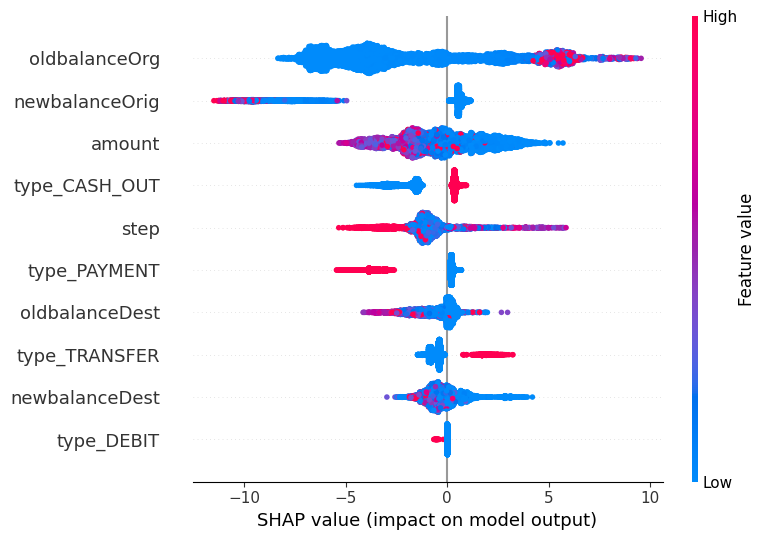

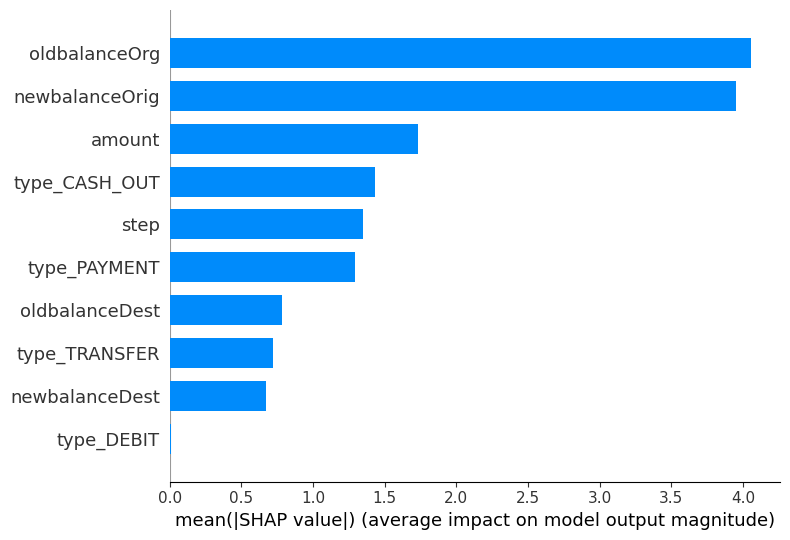

In [34]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")


## 4] SHAP Force Plot (Local explanation for ONE transaction)

Positive SHAP values indicate feature values that push a transaction toward being classified as fraud, whereas negative SHAP values push the prediction toward non-fraud.

In [35]:
shap.initjs()

sample = X_test.iloc[5]
shap.force_plot(explainer.expected_value, shap_values[5], sample)

## 5] SHAP waterfall plot (cleaner version for local explaination)

Positive SHAP values indicate feature values that push a transaction toward being classified as fraud, whereas negative SHAP values push the prediction toward non-fraud.

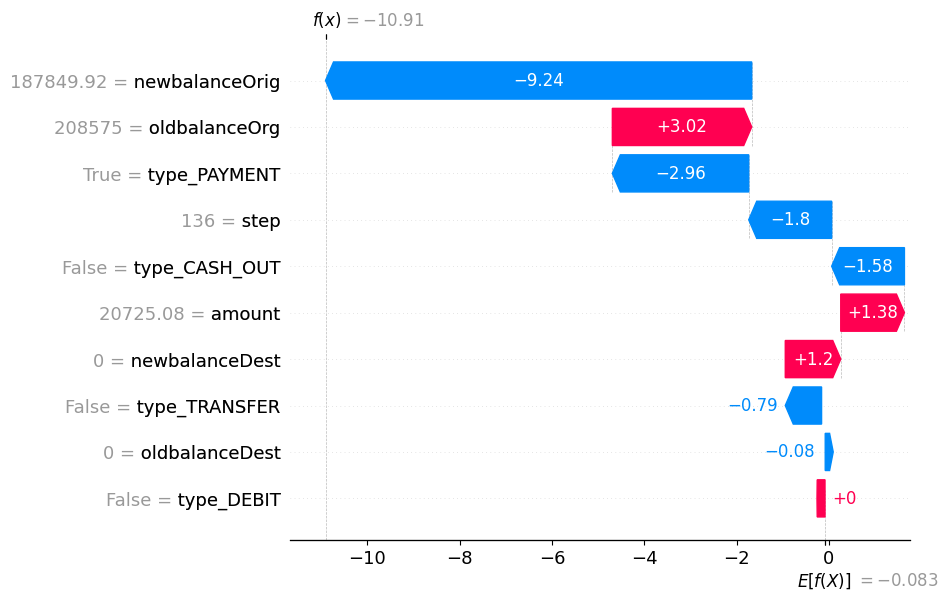

In [36]:
shap.plots.waterfall(shap.Explanation(values=shap_values[5],
                                      base_values=explainer.expected_value,
                                      data=X_test.iloc[5],
                                      feature_names=X_test.columns))
